### RAOP Baseline Notebook

Shane Kramer, Monali Narayanaswami, Sybil Santos-Burgan, Jose Torres

Semester: Spring 2022

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.feature_extraction.text import *
import nltk

import json 
import pandas as pd 
from pandas import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns

### Load Data

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

# Can configure the list below to filter columns from original training data set
test_cols = ['request_title', 'request_text', 'request_number_of_comments_at_retrieval', 'requester_received_pizza']

# Read JSON file from google drive
#train_df = pd.read_json('/content/drive/MyDrive/W207/FinalProject/w207_final_project/src/data/train.json')

# Read JSON file from data folder
train_df = pd.read_json('../data/random-acts-of-pizza/train.json')
test_df = pd.read_json('../data/random-acts-of-pizza/test.json')

filtered_df = train_df[test_cols]

# Add word count column
filtered_df['request_text_count'] = filtered_df['request_text'].str.count(' ') + 1
filtered_df.head()

<ipython-input-2-bab9c50da047>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['request_text_count'] = filtered_df['request_text'].str.count(' ') + 1


,request_title,request_text,request_number_of_comments_at_retrieval,requester_received_pizza,request_text_count
0,Request Colorado Springs Help Us Please,Hi I am in need of food for my 4 children we a...,0,False,67
1,"[Request] California, No cash and I could use ...",I spent the last money I had on gas today. Im ...,0,False,16
2,"[Request] Hungry couple in Dundee, Scotland wo...",My girlfriend decided it would be a good idea ...,0,False,59
3,"[Request] In Canada (Ontario), just got home f...","It's cold, I'n hungry, and to be completely ho...",4,False,29
4,[Request] Old friend coming to visit. Would LO...,hey guys:\n I love this sub. I think it's grea...,5,False,102


### Divide Data into Training and Test Sets

In [3]:
# Now need to split into features and targets
feature_cols = ['request_text_count', 'request_number_of_comments_at_retrieval']
X = filtered_df[feature_cols]
Y = filtered_df.requester_received_pizza

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25,random_state=0)

### Examine Data

In [4]:
print('training data shape:', X_train.shape)
print('training label shape:', X_test.shape)
print('test data shape:', Y_train.shape)
print('test label shape:', Y_test.shape)


training data shape: (3030, 2)
training label shape: (1010, 2)
test data shape: (3030,)
test label shape: (1010,)



For first 5 training examples, print the title of request

In [5]:
def display_request(num_examples=5):

    for i in range(num_examples):
        print(filtered_df.iloc[i]['request_title']) 
        print(filtered_df.iloc[i]['request_text'])
        print('Received Pizza: ', filtered_df.iloc[i]['requester_received_pizza']) 
        print('\n')  

        
display_request(5)

Request Colorado Springs Help Us Please
Hi I am in need of food for my 4 children we are a military family that has really hit hard times and we have exahusted all means of help just to be able to feed my family and make it through another night is all i ask i know our blessing is coming so whatever u can find in your heart to give is greatly appreciated
Received Pizza:  False


[Request] California, No cash and I could use some dinner
I spent the last money I had on gas today. Im broke until next Thursday :(
Received Pizza:  False


[Request] Hungry couple in Dundee, Scotland would love some pizza!
My girlfriend decided it would be a good idea to get off at Perth bus station when she was coming to visit me and has since had to spend all her money on a taxi to get to me here in Dundee. Any chance some kind soul would get us some pizza since we don't have any cash anymore?
Received Pizza:  False


[Request] In Canada (Ontario), just got home from school. Need pizza.
It's cold, I'n hungr

### Review Dataset Skewness


<AxesSubplot:xlabel='requester_received_pizza'>

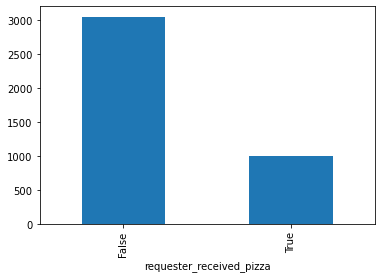

In [6]:

filtered_df.groupby('requester_received_pizza').size().plot(kind = "bar")


### Models

In [7]:
# Create and train model using train data
logreg = LogisticRegression()
logreg.fit(X_train,Y_train)
Y_pred = logreg.predict(X)

In [8]:
# Run model against test data
Y_test_pred = logreg.predict(X_test)

In [9]:
# Look at confusion matrix
cnf_matrix = metrics.confusion_matrix(Y_test, Y_test_pred)
cnf_matrix

array([[732,  33],
       [216,  29]], dtype=int64)

(3030,)


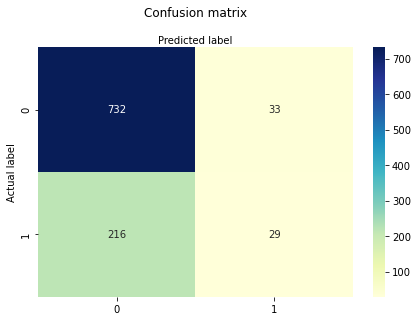

In [10]:
# Plot results
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print(Y_train.shape)

In [11]:
# Output results
print("Accuracy:",metrics.accuracy_score(Y, Y_pred))
print("Precision:",metrics.precision_score(Y, Y_pred))
print("Recall:",metrics.recall_score(Y, Y_pred))

Accuracy: 0.7589108910891089
Precision: 0.5416666666666666
Recall: 0.13078470824949698


### Rebalancing Dataset
requester_received_pizza is imbalanced

In [12]:
# Now need to split into features and targets
feature_cols = ['request_text_count', 'request_number_of_comments_at_retrieval','requester_received_pizza']
X = filtered_df[feature_cols]
Y = filtered_df.requester_received_pizza

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25,random_state=0)

# separate minority and majority classes
negative = X_train[X_train.requester_received_pizza==0]
positive = X_train[X_train.requester_received_pizza==1]

# upsample minority
pos_upsampled = resample(positive,replace=True, n_samples=len(negative), random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([negative, pos_upsampled])
# check new class counts
upsampled.requester_received_pizza.value_counts()

Y_train = upsampled['requester_received_pizza']
X_train = upsampled.drop(['requester_received_pizza'], axis=1)
Y_test = X_test['requester_received_pizza']
X_test = X_test.drop(['requester_received_pizza'], axis=1)
Y = X['requester_received_pizza']
X = X.drop(['requester_received_pizza'], axis=1)

#Convert categorical vriables to dummy variables
X = pd.get_dummies(X, drop_first=True)
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25,random_state=0)

print('Resampled requester_received_pizza')
print( upsampled.requester_received_pizza.value_counts())
print('training data shape:', X_train.shape)
print('training label shape:', Y_train.shape)

print('test label shape:', X_test.shape)
print('test label shape:', Y_test.shape)

Resampled requester_received_pizza
True     2281
False    2281
Name: requester_received_pizza, dtype: int64
training data shape: (4562, 2)
training label shape: (4562,)
test label shape: (1010, 2)
test label shape: (1010,)


<AxesSubplot:xlabel='requester_received_pizza'>

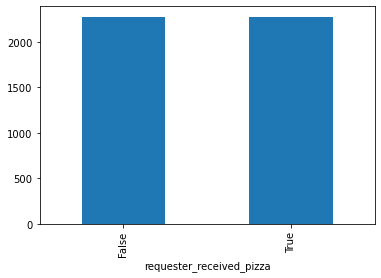

In [13]:
upsampled.groupby('requester_received_pizza').size().plot(kind = "bar")

### Model after Rebalance

In [14]:
# Create and train model using train data
logreg = LogisticRegression()
logreg.fit(X_train,Y_train)

LogisticRegression()

In [15]:
# Run model against test data
Y_test_pred = logreg.predict(X_test)

In [16]:
# Look at confusion matrix
cnf_matrix = metrics.confusion_matrix(Y_test, Y_test_pred)
cnf_matrix

array([[595, 170],
       [107, 138]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

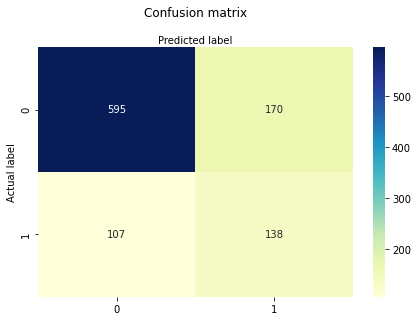

In [17]:
# Plot results
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [18]:
# Output results
print("Accuracy:",metrics.accuracy_score(Y, Y_pred))
print("Precision:",metrics.precision_score(Y, Y_pred))
print("Recall:",metrics.recall_score(Y, Y_pred))

Accuracy: 0.7589108910891089
Precision: 0.5416666666666666
Recall: 0.13078470824949698
